# Problem set 2: Machine Learning 2024.
## Alumnos: Ara Francisco, Corradi Valentin, Di Placido Pedro.

In [1350]:
import numpy as np
import pandas as pd

## General Instructions

El principal objetivo es construir un modelo que prediga la pobreza de los hogares. Un hogar es clasificado seg√∫n la siguiente funci√≥n indicadora:

$$
poor = I(Inc < Pl)
$$

Donde I indica si los ingresos de la familia est√°n por debajo de cierto umbral.

Entonces, podemos seguir 2 caminos para hacer esta clasificaci√≥n:

1 - Tomarlo como un problema de clasificaci√≥n, donde se prediga 0 si no es pobre y 1 si lo es

2 - Predecir el ingreso, y luego fijarse si esta por debajo o por encima del umbral de pobreza.




## Introduction 



In [1351]:
import zipfile

zip_path = "mlunlp-2024-ps-2.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Listar todos los archivos dentro del ZIP
    print(zip_ref.namelist())

['mlunlp-2024-ps-2/', '__MACOSX/._mlunlp-2024-ps-2', 'mlunlp-2024-ps-2/train_hogares.csv', '__MACOSX/mlunlp-2024-ps-2/._train_hogares.csv', 'mlunlp-2024-ps-2/ddi-documentation-spanish-608.pdf', '__MACOSX/mlunlp-2024-ps-2/._ddi-documentation-spanish-608.pdf', 'mlunlp-2024-ps-2/test_personas.csv', '__MACOSX/mlunlp-2024-ps-2/._test_personas.csv', 'mlunlp-2024-ps-2/train_personas.csv', '__MACOSX/mlunlp-2024-ps-2/._train_personas.csv', 'mlunlp-2024-ps-2/test_hogares.csv', '__MACOSX/mlunlp-2024-ps-2/._test_hogares.csv', 'mlunlp-2024-ps-2/sample_submission.csv', '__MACOSX/mlunlp-2024-ps-2/._sample_submission.csv']


In [1352]:
# import zipfile
import pandas as pd

# Ruta al archivo ZIP
zip_path = "mlunlp-2024-ps-2.zip"

# Leer archivos directamente desde el ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Cargar los datos usando las rutas correctas
    with zip_ref.open('mlunlp-2024-ps-2/train_hogares.csv') as train_hogares_file:
        train_hogares = pd.read_csv(train_hogares_file)
    with zip_ref.open('mlunlp-2024-ps-2/train_personas.csv') as train_personas_file:
        train_personas = pd.read_csv(train_personas_file)
    with zip_ref.open('mlunlp-2024-ps-2/test_hogares.csv') as test_hogares_file:
        test_hogares = pd.read_csv(test_hogares_file)
    with zip_ref.open('mlunlp-2024-ps-2/test_personas.csv') as test_personas_file:
        test_personas = pd.read_csv(test_personas_file)
    with zip_ref.open('mlunlp-2024-ps-2/sample_submission.csv') as sample_submission_file:
        sample_submission = pd.read_csv(sample_submission_file)

# Inspeccionar los datos
print("Datos de train_hogares:")
print(train_hogares.head())
print("Datos de train_personas:")
print(train_personas.head())


Datos de train_hogares:
                         id  Clase   Dominio  P5000  P5010  P5090  P5100  \
0  8d0193e328305a042001a35f      1  MEDELLIN      4      2      1    NaN   
1  cf7491d7f2cc9c216bd009e7      1  MEDELLIN      5      4      3    NaN   
2  d90a57f64d2a84dbacbed2a5      1  MEDELLIN      4      2      1    NaN   
3  db34e387a94a783188ab3a33      1  MEDELLIN      3      1      1    NaN   
4  97bbef785824746ecab09c6f      1  MEDELLIN      4      3      3    NaN   

      P5130     P5140  Nper  ...       Ingpcug             Li            Lp  \
0  400000.0       NaN     5  ...  5.816661e+05  122809.534158  289878.24715   
1       NaN  250000.0     4  ...  1.612500e+05  122809.534158  289878.24715   
2  700000.0       NaN     3  ...  2.000000e+06  122809.534158  289878.24715   
3  450000.0       NaN     1  ...  2.450000e+06  122809.534158  289878.24715   
4       NaN  500000.0     5  ...  2.520000e+05  122809.534158  289878.24715   

   Pobre  Indigente  Npobres  Nindigentes   

In [1353]:
# Matcheamos lo individual con el hogar. previamente le agregamos los sufijos _p o _h para saber su base original.

# # Personas
# train_personas = train_personas.rename(columns=lambda col: f"{col}_p" if col != "id" else col)
# train_hogares = train_hogares.rename(columns=lambda col: f"{col}_h" if col != "id" else col)
# train_all = train_personas.merge(train_hogares, on="id", how="inner")  

# #Hogares
# test_personas = test_personas.rename(columns=lambda col: f"{col}_p" if col != "id" else col)
# test_hogares = test_hogares.rename(columns=lambda col: f"{col}_h" if col != "id" else col)
# test_all = test_personas.merge(test_hogares, on="id", how="inner")

# print(f'Dimensi√≥n train_all: {train_all.shape}, Dimensi√≥n test_all: {test_all.shape}')

In [1354]:
print(train_hogares.shape)
print(train_personas.shape)
print(test_hogares.shape)
print(test_personas.shape)

(164960, 23)
(543109, 135)
(66168, 16)
(219644, 63)


Vemos que la dimensi√≥n de los df difiere. La muestra de testeo no tiene las variables relacionadas al ingreso o el indicador de pobreza/indigencia. Esto no debiera afectarnos ya que es la variable que buscamos predecir. Recordemos que un metodo a utilizar es categ√≥rico, donde en base a los predictores se clasifica directamente en pobre o no pobre, y el otro es "indirecto", donde primero se predice el ingreso y en base a eso se hace luego la clasificaci√≥n.

In [1355]:
#print(train_hogares.columns)
#print(test_hogares.columns)

print(f'Las variables que difieren en los hogares son: \n{set(train_hogares.columns) - set(test_hogares.columns)}')

#print(train_personas.columns)
#print(test_personas.columns)

print(f'Las variables que difieren en las personas son: \n {set(train_personas.columns) - set(test_personas.columns)}')

Las variables que difieren en los hogares son: 
{'Ingtotugarr', 'Npobres', 'Ingpcug', 'Ingtotug', 'Nindigentes', 'Pobre', 'Indigente'}
Las variables que difieren en las personas son: 
 {'P6545s2', 'P6585s3a2', 'Iof3hes', 'Iof1es', 'P6585s2a2', 'Estrato1', 'Cclasnr2', 'P6510s2', 'P6630s6a1', 'P6580s2', 'Iof3ies', 'P7070', 'Ingtotob', 'P7510s5a1', 'P7500s3a1', 'Cclasnr8', 'P6760', 'Isa', 'Impa', 'Iof3i', 'P7510s1a1', 'Iof2', 'Imdies', 'P7472s1', 'Imdi', 'P6630s2a1', 'Iof6', 'Iof6es', 'P6585s1a2', 'Ie', 'P7500s2a1', 'P6600s1', 'Cclasnr5', 'Iof2es', 'P7500s1a1', 'P6500', 'Ingtot', 'P6750', 'P6610s1', 'P7140s2', 'P7422s1', 'P6620s1', 'Cclasnr11', 'P6590s1', 'P6585s4a2', 'P6630s4a1', 'P6585s4a1', 'Iees', 'P6580s1', 'P6585s2a1', 'Iof1', 'P6585s1a1', 'P7510s3a1', 'P550', 'P6545s1', 'P6630s3a1', 'Isaes', 'P6585s3a1', 'Iof3h', 'Ingtotes', 'P6510s1', 'Cclasnr7', 'P7500s1', 'P7510s7a1', 'P6630s1a1', 'P7510s6a1', 'Impaes', 'Cclasnr4', 'Cclasnr3', 'P7510s2a1', 'Cclasnr6', 'P7140s1'}


In [1356]:
# print(train_hogares.columns)
print(F'test per: {train_hogares.columns}')

test per: Index(['id', 'Clase', 'Dominio', 'P5000', 'P5010', 'P5090', 'P5100', 'P5130',
       'P5140', 'Nper', 'Npersug', 'Ingtotug', 'Ingtotugarr', 'Ingpcug', 'Li',
       'Lp', 'Pobre', 'Indigente', 'Npobres', 'Nindigentes', 'Fex_c', 'Depto',
       'Fex_dpto'],
      dtype='object')


In [1357]:
import seaborn as sns
import matplotlib.pyplot as plt

In [1358]:
print("Variables en train_hogares:")
print(train_hogares.columns)


Variables en train_hogares:
Index(['id', 'Clase', 'Dominio', 'P5000', 'P5010', 'P5090', 'P5100', 'P5130',
       'P5140', 'Nper', 'Npersug', 'Ingtotug', 'Ingtotugarr', 'Ingpcug', 'Li',
       'Lp', 'Pobre', 'Indigente', 'Npobres', 'Nindigentes', 'Fex_c', 'Depto',
       'Fex_dpto'],
      dtype='object')


## Variables Seleccionadas: Hogares

- **`id`**: Identificador √∫nico del hogar.
- **`Pobre`**: Indicador de pobreza del hogar.
- **`Ingpcug`**: Ingreso per c√°pita del hogar.
- **`P5010`**: N√∫mero de cuartos donde duermen las personas.
- **`P5090`**: R√©gimen de tenencia de la vivienda (propia, alquilada, etc.).
- **`P5130`**: Monto estimado de arriendo.
- **`Nper`**: N√∫mero de personas en el hogar.
- **`Clase`**: Clasificaci√≥n del hogar (cabecera o resto del √°rea).
- **`Fex_c`**: Factor de expansi√≥n anualizado.


In [1359]:
columnas_hogares = ['id', 'P5000', 'P5010', 'P5090', 'P5130', 'Nper', 'Ingpcug', 'Clase', 'Fex_c', 'Pobre']
train_hogares = train_hogares[columnas_hogares]

## Variables Seleccionadas: Personas

- **`id`**: Identificador √∫nico del individuo.
- **`P6020`**: Sexo (1 hombre, 2 mujer).
- **`P6040`**: Edad de la persona.
- **`P6050`**: Parentezco con el jefe de hogar.
- **`P6090`**: Afilaci√≥n a la seguridad social.
- **`P6210`**: Nivel educativo alcanzado.
- **`P6430`**: Tipo de empleo
- **`P6585s1`**: subsidio por alimentacion. 
- **`P6585s3a1`**: Subsidio familiar.(sacado)
- **`P7040`**: Dummy de ocupaci√≥n secundaria (1 tiene ,2 no tiene)
- **`P7045`**: Horas trabajadas en ocupacion secundaria.
- **`P6800`**: Horas trabajadas por semana. (sacado)
- **`P6870`**: Numero de empleados de la empresa. (sacado)
- **`Ingtot`**: Ingreso total del individuo.
- **`Oc`**: Dummy de ocupaci√≥n.

In [1360]:
# Selecci√≥n de columnas relevantes incluyendo 'Pobre' para el merge
columnas_personas = ['id','Orden', 'P6020', 'P6040','P6050','P6090', 'P6210','P6430','P6585s1','P6585s3a1', 'P7040','P7045','Oc']
train_personas = train_personas[columnas_personas]

In [1361]:
# Crear una columna dummy que indique si el hogar recibi√≥ subsidio
train_personas['recibio_subsidio'] = ((train_personas['P6585s1'] > 0) | (train_personas['P6585s3a1'] > 0)).astype(int)

# Mostrar las primeras filas para verificar
print(train_personas[['id', 'P6585s1', 'P6585s3a1', 'recibio_subsidio']].head())

                         id  P6585s1  P6585s3a1  recibio_subsidio
0  8d0193e328305a042001a35f      2.0    75000.0                 1
1  8d0193e328305a042001a35f      NaN        NaN                 0
2  8d0193e328305a042001a35f      2.0    81000.0                 1
3  8d0193e328305a042001a35f      NaN        NaN                 0
4  8d0193e328305a042001a35f      NaN        NaN                 0


In [1362]:
# Ordenar la base de hogares por 'id'
train_hogares = train_hogares.sort_values(by='id')

# Ordenar la base de personas por 'id' y 'orden'
train_personas = train_personas.sort_values(by=['id', 'Orden'])

In [1363]:
# Calculate the proportion of men in each household
train_personas['prop_sexo'] = train_personas.groupby('id')['P6020'].transform(lambda x: (x == 1).sum() / len(x))

# Display the first few rows to verify the calculation
print(train_personas[['id', 'P6020', 'prop_sexo']].head()) #No genera ning√∫n NaN

                              id  P6020  prop_sexo
115620  00004a3f76ed8c33d84a5c70      2        0.4
115621  00004a3f76ed8c33d84a5c70      1        0.4
115622  00004a3f76ed8c33d84a5c70      2        0.4
115618  00004a3f76ed8c33d84a5c70      2        0.4
115619  00004a3f76ed8c33d84a5c70      1        0.4


VER QUE HACEMOS SI GENERA ALGUNOS NAN

In [1364]:
# Filtrar la fila correspondiente al jefe del hogar (P6050 == 1)
jefe_hogar = train_personas[train_personas['P6050'] == 1]

# Crear un diccionario con la relaci√≥n 'id' del hogar y la posici√≥n ocupacional del jefe (P6430)
jefe_ocupacion = jefe_hogar.set_index('id')['P6430'].to_dict()

# Asignar la posici√≥n ocupacional del jefe a la nueva variable 'ocup_jefe' en la train_personas
train_personas['ocup_jefe'] = train_personas['id'].map(jefe_ocupacion)

# Mostrar las primeras filas para verificar
print(train_personas[['id', 'ocup_jefe']].head(5))

                              id  ocup_jefe
115620  00004a3f76ed8c33d84a5c70        NaN
115621  00004a3f76ed8c33d84a5c70        NaN
115622  00004a3f76ed8c33d84a5c70        NaN
115618  00004a3f76ed8c33d84a5c70        NaN
115619  00004a3f76ed8c33d84a5c70        NaN


In [1365]:
# Crear una columna que indique si la persona est√° ocupada (1 si est√° ocupada, 0 si no)
train_personas['ocupada'] = (train_personas['Oc'] == 1).astype(int)

# Calcular la proporci√≥n de personas ocupadas por hogar
train_personas['prop_ocup'] = train_personas.groupby('id')['ocupada'].transform('mean')

# Mostrar las primeras filas para verificar
print(train_personas[['id', 'ocupada', 'prop_ocup']].head(5))

                              id  ocupada  prop_ocup
115620  00004a3f76ed8c33d84a5c70        0        0.2
115621  00004a3f76ed8c33d84a5c70        1        0.2
115622  00004a3f76ed8c33d84a5c70        0        0.2
115618  00004a3f76ed8c33d84a5c70        0        0.2
115619  00004a3f76ed8c33d84a5c70        0        0.2


In [1366]:
# Crear una columna que indique si la persona es mayor a 10 a√±os (1 si es mayor a 10 a√±os, 0 si no)
train_personas['mayor_10'] = (train_personas['P6040'] > 10).astype(int)

# Calcular la proporci√≥n de personas mayores a 10 a√±os por hogar
train_personas['prop_mayores10'] = train_personas.groupby('id')['mayor_10'].transform('mean')

# Mostrar las primeras filas para verificar
print(train_personas[['id', 'P6040', 'mayor_10', 'prop_mayores10']].head())

                              id  P6040  mayor_10  prop_mayores10
115620  00004a3f76ed8c33d84a5c70     31         1             0.6
115621  00004a3f76ed8c33d84a5c70     36         1             0.6
115622  00004a3f76ed8c33d84a5c70     15         1             0.6
115618  00004a3f76ed8c33d84a5c70      6         0             0.6
115619  00004a3f76ed8c33d84a5c70      3         0             0.6


revisar nan de la variable P6090

In [1367]:
# Filter out rows where P6090 is 9
train_personas = train_personas[train_personas['P6090'] != 9]

# Create a column that indicates if the person is affiliated with social security (1 if affiliated, 0 if not)
train_personas['afiliado'] = (train_personas['P6090'] == 1).astype(int)

# Calculate the proportion of affiliated individuals in each household
train_personas['prop_afiliado'] = train_personas.groupby('id')['afiliado'].transform('mean')

# Display the first few rows to verify the calculation
print(train_personas[['id', 'P6090', 'afiliado', 'prop_afiliado']].head())

                              id  P6090  afiliado  prop_afiliado
115620  00004a3f76ed8c33d84a5c70    1.0         1            0.6
115621  00004a3f76ed8c33d84a5c70    1.0         1            0.6
115622  00004a3f76ed8c33d84a5c70    1.0         1            0.6
115618  00004a3f76ed8c33d84a5c70    NaN         0            0.6
115619  00004a3f76ed8c33d84a5c70    NaN         0            0.6


In [1368]:
# Create a column that indicates if the person has a secondary occupation (1 if they have, 0 if not)
train_personas['ocupacion_secundaria'] = (train_personas['P7040'] == 1).astype(int)

# Calculate the proportion of people with a secondary occupation in each household
train_personas['prop_ocup2'] = train_personas.groupby('id')['ocupacion_secundaria'].transform('mean')

# Display the first few rows to verify the calculation
print(train_personas[['id', 'P7040', 'ocupacion_secundaria', 'prop_ocup2']].head())

                              id  P7040  ocupacion_secundaria  prop_ocup2
115620  00004a3f76ed8c33d84a5c70    NaN                     0         0.0
115621  00004a3f76ed8c33d84a5c70    2.0                     0         0.0
115622  00004a3f76ed8c33d84a5c70    NaN                     0         0.0
115618  00004a3f76ed8c33d84a5c70    NaN                     0         0.0
115619  00004a3f76ed8c33d84a5c70    NaN                     0         0.0


In [1369]:
# Agrupar por 'id' y quedarnos con la primera fila de cada grupo
variables = ['id', 'prop_sexo', 'ocup_jefe', 'ocupada', 'prop_ocup', 'mayor_10', 'prop_mayores10', 'recibio_subsidio', 'ocupacion_secundaria', 'prop_ocup2','prop_afiliado']
train_personas_agg = train_personas[variables].drop_duplicates(subset='id', keep='first').reset_index(drop=True)

# Mostrar las primeras filas para verificar
display(train_personas_agg.head())

id  prop_sexo  ocup_jefe  ocupada  prop_ocup  \
0  00004a3f76ed8c33d84a5c70   0.400000        NaN        0   0.200000   
1  000088edf78cfaaf1791beba   0.333333        NaN        0   0.333333   
2  00009b13480f6770b6a4d1e9   0.666667        4.0        1   0.666667   
3  0000b1899fb63a7bf0b73ccf   0.500000        4.0        1   0.500000   
4  0000f3ec65ccacadfcc59f32   0.333333        NaN        0   0.666667   

   mayor_10  prop_mayores10  recibio_subsidio  ocupacion_secundaria  \
0         1        0.600000                 0                     0   
1         1        0.666667                 0                     0   
2         1        1.000000                 0                     0   
3         1        1.000000                 0                     0   
4         1        1.000000                 0                     0   

   prop_ocup2  prop_afiliado  
0    0.000000       0.600000  
1    0.333333       0.666667  
2    0.000000       1.000000  
3    0.000000       1.000000  
4    0.000000       1.000000

In [1370]:
print(f"Number of rows in train_personas_agg: {train_personas_agg.shape[0]}")
print(f"Number of rows in train_hogares: {train_hogares.shape[0]}")

Number of rows in train_personas_agg: 164933
Number of rows in train_hogares: 164960


In [1371]:
# Hacer un merge de train_hogares con train_personas_agg usando la columna 'id' con un inner join
train_hogares2 = train_hogares.merge(train_personas_agg, on='id', how='inner')

# Mostrar las primeras filas para verificar
train_hogares2.head()

id  P5000  P5010  P5090     P5130  Nper  \
0  00004a3f76ed8c33d84a5c70      3      2      1  250000.0     5   
1  000088edf78cfaaf1791beba      3      2      3       NaN     3   
2  00009b13480f6770b6a4d1e9      4      3      1  700000.0     3   
3  0000b1899fb63a7bf0b73ccf      5      2      1   70000.0     2   
4  0000f3ec65ccacadfcc59f32      4      2      1  350000.0     3   

         Ingpcug  Clase       Fex_c  Pobre  prop_sexo  ocup_jefe  ocupada  \
0  265285.883333      1  535.091737      1   0.400000        NaN        0   
1  344166.666667      1   48.637019      0   0.333333        NaN        0   
2  833333.333333      1   18.831041      0   0.666667        4.0        1   
3  355000.000000      2   48.193596      0   0.500000        4.0        1   
4  720830.666667      1   11.184193      0   0.333333        NaN        0   

   prop_ocup  mayor_10  prop_mayores10  recibio_subsidio  \
0   0.200000         1        0.600000                 0   
1   0.333333         1        0.666667                 0   
2   0.666667         1        1.000000                 0   
3   0.500000         1        1.000000                 0   
4   0.666667         1        1.000000                 0   

   ocupacion_secundaria  prop_ocup2  prop_afiliado  
0                     0    0.000000       0.600000  
1                     0    0.333333       0.666667  
2                     0    0.000000       1.000000  
3                     0    0.000000       1.000000  
4                     0    0.000000       1.000000

#### Hasta aca llegamos. continuamos sabado.

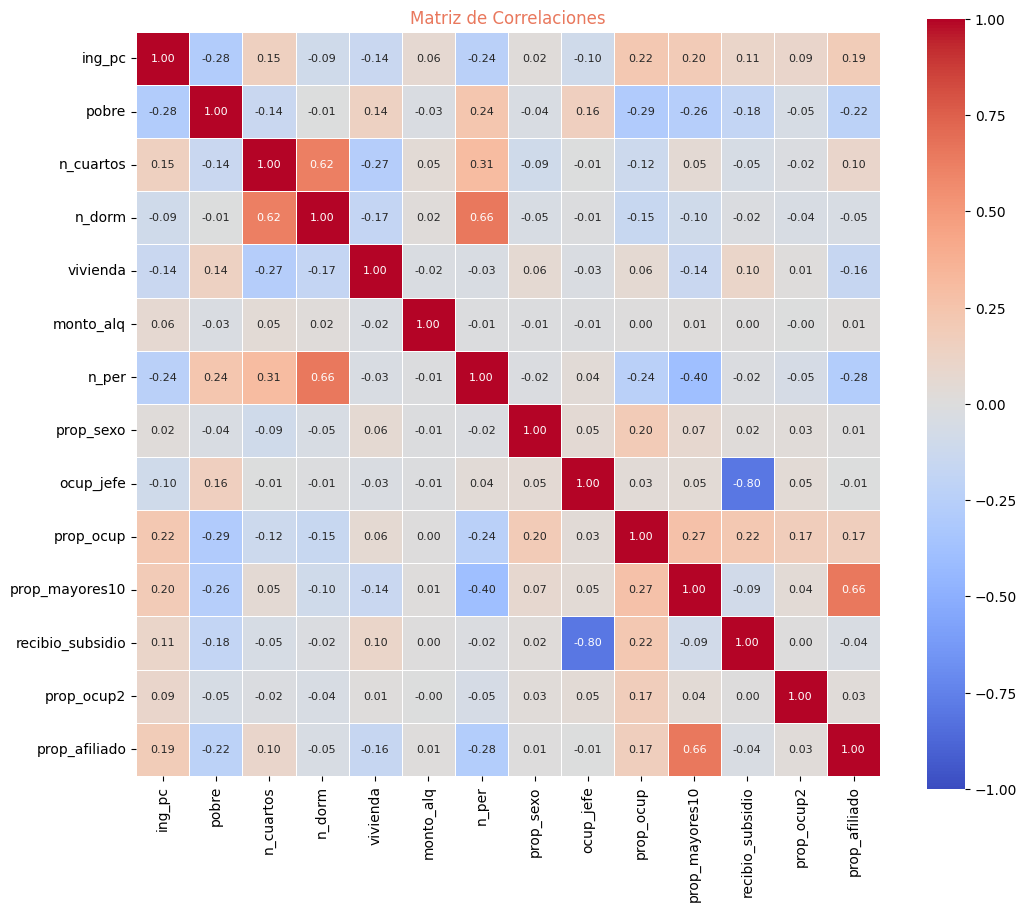

In [1372]:
# Renombrar las columnas
train_hogares2.rename(columns={
    'P5000': 'n_cuartos',
    'P5010': 'n_dorm',
    'P5090': 'vivienda',
    'P5130': 'monto_alq',
    'Nper': 'n_per',
    'Pobre': 'pobre',
    'Ingpcug': 'ing_pc',
    'Fex_c': 'fex_c'
}, inplace=True)

# Seleccionar las columnas de inter√©s para la matriz de correlaciones
columnas_interes = ['ing_pc', 'pobre', 'n_cuartos','n_dorm','vivienda', 'monto_alq','n_per', 'prop_sexo', 'ocup_jefe', 'prop_ocup', 'prop_mayores10', 'recibio_subsidio', 'prop_ocup2', 'prop_afiliado']

# Calcular la matriz de correlaciones
corr_matrix = train_hogares2[columnas_interes].corr()

# Crear el mapa de calor con escala fija de -1 a 1
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, cmap='coolwarm', annot=True, fmt='.2f',
    cbar=True, square=True, annot_kws={'size': 8}, linewidth=.5,
    vmin=-1, vmax=1  # Configurar la escala fija de colores
)

# Personalizar el gr√°fico
plt.title('Matriz de Correlaciones', color='#E9785D')
plt.show()

#### union test

In [1373]:
columnas_hogares = ['id', 'P5000', 'P5010', 'P5090', 'P5130', 'Nper', 'Clase', 'Fex_c']
test_hogares = test_hogares[columnas_hogares]
# Selecci√≥n de columnas relevantes incluyendo 'Pobre' para el merge
columnas_personas = ['id','Orden', 'P6020', 'P6040','P6050','P6090', 'P6210','P6430','P6585s1', 'P7040','P7045','Oc']
test_personas = test_personas[columnas_personas]
# Crear una columna dummy que indique si el hogar recibi√≥ subsidio
test_personas['recibio_subsidio'] = ((test_personas['P6585s1'] > 0)).astype(int)

In [1374]:


# Mostrar las primeras filas para verificar
print(test_personas[['id', 'P6585s1', 'recibio_subsidio']].head())
# Ordenar la base de hogares por 'id'
test_hogares = test_hogares.sort_values(by='id')

# Ordenar la base de personas por 'id' y 'orden'
test_personas = test_personas.sort_values(by=['id', 'Orden'])
# Calculate the proportion of men in each household
test_personas['prop_sexo'] = test_personas.groupby('id')['P6020'].transform(lambda x: (x == 1).sum() / len(x))

# Display the first few rows to verify the calculation
print(test_personas[['id', 'P6020', 'prop_sexo']].head()) #No genera ning√∫n NaN
# Filtrar la fila correspondiente al jefe del hogar (P6050 == 1)
jefe_hogar = test_personas[test_personas['P6050'] == 1]

# Crear un diccionario con la relaci√≥n 'id' del hogar y la posici√≥n ocupacional del jefe (P6430)
jefe_ocupacion = jefe_hogar.set_index('id')['P6430'].to_dict()

# Asignar la posici√≥n ocupacional del jefe a la nueva variable 'ocup_jefe' en la test_personas
test_personas['ocup_jefe'] = test_personas['id'].map(jefe_ocupacion)

# Mostrar las primeras filas para verificar
print(test_personas[['id', 'ocup_jefe']].head(5))
# Crear una columna que indique si la persona est√° ocupada (1 si est√° ocupada, 0 si no)
test_personas['ocupada'] = (test_personas['Oc'] == 1).astype(int)

# Calcular la proporci√≥n de personas ocupadas por hogar
test_personas['prop_ocup'] = test_personas.groupby('id')['ocupada'].transform('mean')

# Mostrar las primeras filas para verificar
print(test_personas[['id', 'ocupada', 'prop_ocup']].head(5))
# Crear una columna que indique si la persona es mayor a 10 a√±os (1 si es mayor a 10 a√±os, 0 si no)
test_personas['mayor_10'] = (test_personas['P6040'] > 10).astype(int)

# Calcular la proporci√≥n de personas mayores a 10 a√±os por hogar
test_personas['prop_mayores10'] = test_personas.groupby('id')['mayor_10'].transform('mean')

# Mostrar las primeras filas para verificar
print(test_personas[['id', 'P6040', 'mayor_10', 'prop_mayores10']].head())
# Filter out rows where P6090 is 9
test_personas = test_personas[test_personas['P6090'] != 9]

# Create a column that indicates if the person is affiliated with social security (1 if affiliated, 0 if not)
test_personas['afiliado'] = (test_personas['P6090'] == 1).astype(int)

# Calculate the proportion of affiliated individuals in each household
test_personas['prop_afiliado'] = test_personas.groupby('id')['afiliado'].transform('mean')

# Display the first few rows to verify the calculation
print(test_personas[['id', 'P6090', 'afiliado', 'prop_afiliado']].head())
# Create a column that indicates if the person has a secondary occupation (1 if they have, 0 if not)
test_personas['ocupacion_secundaria'] = (test_personas['P7040'] == 1).astype(int)

# Calculate the proportion of people with a secondary occupation in each household
test_personas['prop_ocup2'] = test_personas.groupby('id')['ocupacion_secundaria'].transform('mean')

# Display the first few rows to verify the calculation
print(test_personas[['id', 'P7040', 'ocupacion_secundaria', 'prop_ocup2']].head())

                         id  P6585s1  recibio_subsidio
0  3279230a4917cdf883df34cd      2.0                 1
1  3279230a4917cdf883df34cd      NaN                 0
2  3279230a4917cdf883df34cd      2.0                 1
3  3279230a4917cdf883df34cd      NaN                 0
4  01bd1f72445acc719d19bd25      NaN                 0
                              id  P6020  prop_sexo
114499  00007322a7918c7799e7a514      2        0.0
101740  0004847804c0618d4633b196      1        0.5
101741  0004847804c0618d4633b196      2        0.5
40523   0004add76858a3b0cc39eb9b      1        0.8
40524   0004add76858a3b0cc39eb9b      2        0.8
                              id  ocup_jefe
114499  00007322a7918c7799e7a514        1.0
101740  0004847804c0618d4633b196        4.0
101741  0004847804c0618d4633b196        4.0
40523   0004add76858a3b0cc39eb9b        2.0
40524   0004add76858a3b0cc39eb9b        2.0
                              id  ocupada  prop_ocup
114499  00007322a7918c7799e7a514        1      

In [1375]:
# Agrupar por 'id' y quedarnos con la primera fila de cada grupo
variables = ['id', 'prop_sexo', 'ocup_jefe', 'ocupada', 'prop_ocup', 'mayor_10', 'prop_mayores10', 'recibio_subsidio', 'ocupacion_secundaria', 'prop_ocup2','prop_afiliado']
test_personas_agg = test_personas[variables].drop_duplicates(subset='id', keep='first').reset_index(drop=True)

# Mostrar las primeras filas para verificar
display(test_personas_agg.head())

id  prop_sexo  ocup_jefe  ocupada  prop_ocup  \
0  00007322a7918c7799e7a514        0.0        1.0        1   1.000000   
1  0004847804c0618d4633b196        0.5        4.0        1   0.500000   
2  0004add76858a3b0cc39eb9b        0.8        2.0        1   0.200000   
3  000804ac64d779b35ee5edfa        0.5        4.0        1   0.333333   
4  000b6a116b7f95b043a6e77b        0.0        1.0        1   0.500000   

   mayor_10  prop_mayores10  recibio_subsidio  ocupacion_secundaria  \
0         1        1.000000                 1                     1   
1         1        1.000000                 0                     0   
2         1        0.800000                 1                     0   
3         1        0.833333                 0                     0   
4         1        0.500000                 1                     0   

   prop_ocup2  prop_afiliado  
0         1.0       1.000000  
1         0.0       1.000000  
2         0.0       0.600000  
3         0.0       0.833333  
4         0.0       1.000000

In [1376]:
# Hacer un merge de train_hogares con train_personas_agg usando la columna 'id' con un inner join
test_hogares2 = test_hogares.merge(test_personas_agg, on='id', how='inner')

# Mostrar las primeras filas para verificar
test_hogares2.head()

id  P5000  P5010  P5090     P5130  Nper  Clase  \
0  00007322a7918c7799e7a514      3      1      1  600000.0     1      1   
1  0004847804c0618d4633b196      3      1      3       NaN     2      1   
2  0004add76858a3b0cc39eb9b      4      3      3       NaN     5      1   
3  000804ac64d779b35ee5edfa      1      1      4  150000.0     6      1   
4  000b6a116b7f95b043a6e77b      4      2      1  200000.0     2      2   

        Fex_c  prop_sexo  ocup_jefe  ocupada  prop_ocup  mayor_10  \
0   18.600075        0.0        1.0        1   1.000000         1   
1   37.168351        0.5        4.0        1   0.500000         1   
2    9.395218        0.8        2.0        1   0.200000         1   
3    8.689642        0.5        4.0        1   0.333333         1   
4  133.359515        0.0        1.0        1   0.500000         1   

   prop_mayores10  recibio_subsidio  ocupacion_secundaria  prop_ocup2  \
0        1.000000                 1                     1         1.0   
1        1.000000                 0                     0         0.0   
2        0.800000                 1                     0         0.0   
3        0.833333                 0                     0         0.0   
4        0.500000                 1                     0         0.0   

   prop_afiliado  
0       1.000000  
1       1.000000  
2       0.600000  
3       0.833333  
4       1.000000

In [1377]:
# Renombrar las columnas
test_hogares2.rename(columns={
    'P5000': 'n_cuartos',
    'P5010': 'n_dorm',
    'P5090': 'vivienda',
    'P5130': 'monto_alq',
    'Nper': 'n_per',
    'Pobre': 'pobre',
    'Ingpcug': 'ing_pc',
    'Fex_c': 'fex_c'
}, inplace=True)

### Preparo los datos

In [1378]:
# Merge test_hogares2 with sample_submission on 'id'
test_hogares2 = test_hogares2.merge(sample_submission, on='id', how='inner')

# Display the first few rows to verify the merge
test_hogares2.head()

id  n_cuartos  n_dorm  vivienda  monto_alq  n_per  \
0  00007322a7918c7799e7a514          3       1         1   600000.0      1   
1  0004847804c0618d4633b196          3       1         3        NaN      2   
2  0004add76858a3b0cc39eb9b          4       3         3        NaN      5   
3  000804ac64d779b35ee5edfa          1       1         4   150000.0      6   
4  000b6a116b7f95b043a6e77b          4       2         1   200000.0      2   

   Clase       fex_c  prop_sexo  ocup_jefe  ocupada  prop_ocup  mayor_10  \
0      1   18.600075        0.0        1.0        1   1.000000         1   
1      1   37.168351        0.5        4.0        1   0.500000         1   
2      1    9.395218        0.8        2.0        1   0.200000         1   
3      1    8.689642        0.5        4.0        1   0.333333         1   
4      2  133.359515        0.0        1.0        1   0.500000         1   

   prop_mayores10  recibio_subsidio  ocupacion_secundaria  prop_ocup2  \
0        1.000000                 1                     1         1.0   
1        1.000000                 0                     0         0.0   
2        0.800000                 1                     0         0.0   
3        0.833333                 0                     0         0.0   
4        0.500000                 1                     0         0.0   

   prop_afiliado  pobre  
0       1.000000      0  
1       1.000000      1  
2       0.600000      1  
3       0.833333      0  
4       1.000000      0

In [1379]:

y_train = train_hogares2['pobre']
y_test = test_hogares2['pobre']
X_train = train_hogares2.drop(columns=['id', 'pobre', 'fex_c', 'ing_pc'])
X_test = test_hogares2.drop(columns=['id', 'pobre', 'fex_c'])


In [1380]:
print(type(X_train))
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [1381]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

In [1382]:
# Imputar valores faltantes
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

### ElasticNet

In [1410]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
import pandas as pd
import numpy as np

# Crear un imputador para llenar los valores faltantes
imputer = SimpleImputer(strategy='mean')

# Crear un pipeline que primero imputa los valores faltantes y luego ajusta el modelo
pipeline = Pipeline([
    ('imputer', imputer),
    ('model', ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 1], random_state=42))
])

# Entrenar ElasticNet
pipeline.fit(X_train, y_train)

# Predicciones ElasticNet
y_pred_elastic = pipeline.predict(X_test)

# Calcular el MSE
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
print(f"Error cuadr√°tico medio (MSE) en prueba: {mse_elastic:.4f}")

# Convertir predicciones continuas a etiquetas binarias usando un umbral
threshold = 0.5
y_pred_binary = (y_pred_elastic >= threshold).astype(int)

# Calcular m√©tricas
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

# Mostrar los mejores hiperpar√°metros
print(f"Mejor alpha: {pipeline.named_steps['model'].alpha_}")
print(f"Mejor l1_ratio: {pipeline.named_steps['model'].l1_ratio_}")

# Identificar las variables seleccionadas (coeficientes no nulos)
coeficientes = pd.Series(pipeline.named_steps['model'].coef_, index=X_train.columns)
variables_seleccionadas = coeficientes[coeficientes != 0].index
print("Variables seleccionadas por Elastic Net:", list(variables_seleccionadas))

Error cuadr√°tico medio (MSE) en prueba: 0.3395
Accuracy: 0.5009
F1-Score: 0.0000
Mejor alpha: 2755.4900151646966
Mejor l1_ratio: 0.5
Variables seleccionadas por Elastic Net: ['monto_alq']


In [1387]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
import pandas as pd

# Crear un imputador para llenar los valores faltantes
imputer = SimpleImputer(strategy='mean')

# Crear un pipeline que primero imputa los valores faltantes y luego ajusta el modelo
pipeline = Pipeline([
    ('imputer', imputer),
    ('model', ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 1], random_state=42))
])

# Entrenar ElasticNet
pipeline.fit(X_train, y_train)

# Predicciones ElasticNet
y_pred_elastic = pipeline.predict(X_test)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)

print(f"Error cuadr√°tico medio (MSE) en prueba: {mse_elastic:.4f}")
print(f"Mejor alpha: {pipeline.named_steps['model'].alpha_}")
print(f"Mejor l1_ratio: {pipeline.named_steps['model'].l1_ratio_}")

# Identificar las variables seleccionadas (coeficientes no nulos)
coeficientes = pd.Series(pipeline.named_steps['model'].coef_, index=X_train.columns)
variables_seleccionadas = coeficientes[coeficientes != 0].index
print("Variables seleccionadas por Elastic Net:", list(variables_seleccionadas))

Error cuadr√°tico medio (MSE) en prueba: 0.3395
Mejor alpha: 2755.4900151646966
Mejor l1_ratio: 0.5
Variables seleccionadas por Elastic Net: ['monto_alq']


### CART

Accuracy en entrenamiento: 0.8308
Accuracy en prueba: 0.5005
F1-Score en prueba: 0.1883


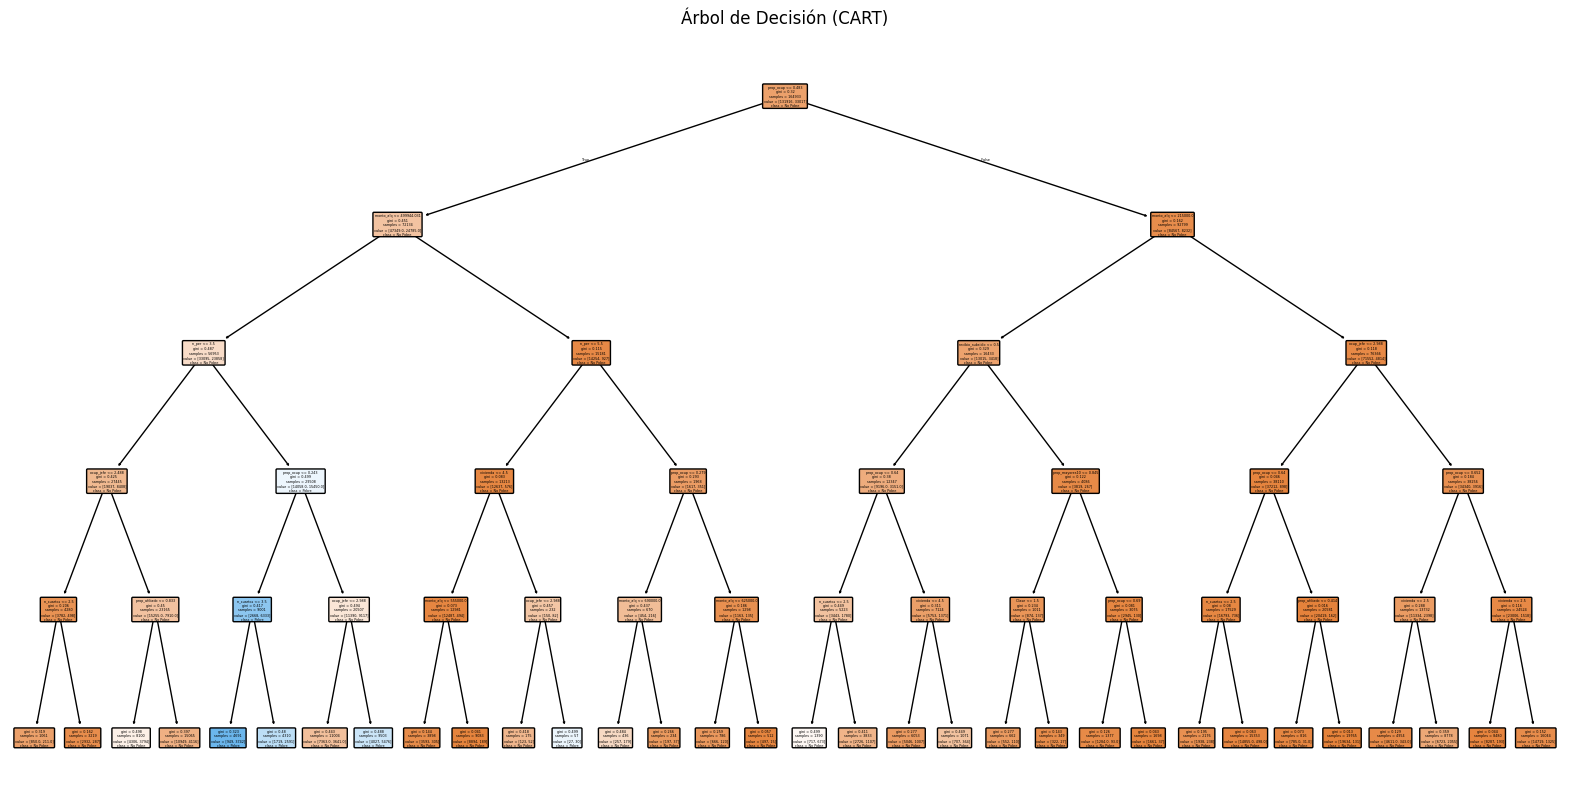

In [1390]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn import tree

# Entrenar el modelo CART
cart_model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)  # Ajustar max_depth seg√∫n sea necesario
cart_model.fit(X_train, y_train)

# Predicciones
y_pred_train = cart_model.predict(X_train)
y_pred_test = cart_model.predict(X_test)

# Evaluaci√≥n del modelo
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print(f"Accuracy en entrenamiento: {train_accuracy:.4f}")
print(f"Accuracy en prueba: {test_accuracy:.4f}")
print(f"F1-Score en prueba: {f1:.4f}")

# Visualizaci√≥n del √°rbol
plt.figure(figsize=(20, 10))
tree.plot_tree(cart_model, feature_names=X_train.columns, class_names=["No Pobre", "Pobre"], filled=True, rounded=True)
plt.title("√Årbol de Decisi√≥n (CART)")
plt.show()

## Resultados del modelo CART

- **Accuracy en entrenamiento:** 83.08%
- **Accuracy en prueba:** 50.05%
- **F1-Score en prueba:** 0.1883
- **Matriz de confusi√≥n:**
  - Verdaderos negativos: 29,278
  - Falsos negativos: 29,183
  - Verdaderos positivos: 3,832
  - Falsos positivos: 3,860

### Interpretaci√≥n
- El modelo muestra **sobreajuste**, con alta precisi√≥n en entrenamiento pero bajo desempe√±o en prueba.
- El F1-Score bajo indica problemas para identificar correctamente los hogares en pobreza.



### Random forest

Accuracy: 0.4991
F1-Score: 0.2384


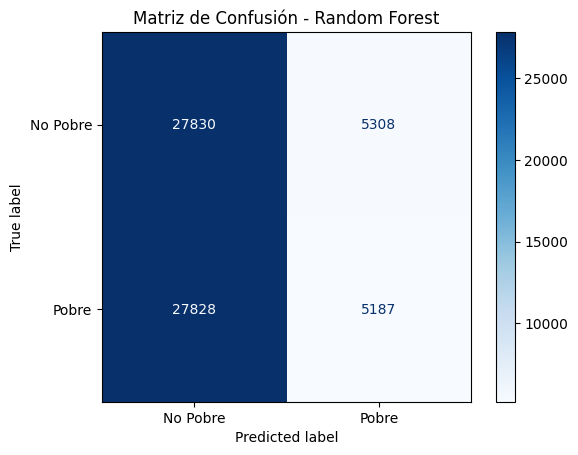

In [1395]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Evaluaci√≥n
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

# Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Pobre", "Pobre"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusi√≥n - Random Forest")
plt.show()

### Resultados de Evaluaci√≥n - Random Forest

- **Accuracy**: 0.4991
  - El modelo clasifica correctamente solo el 49.91% de los casos.
  - Esto es apenas mejor que adivinar al azar si las clases est√°n balanceadas.

- **F1-Score**: 0.2384
  - La media arm√≥nica entre precisi√≥n y recall muestra un desempe√±o bajo.
  - Es probable que el modelo tenga dificultades para clasificar correctamente la clase minoritaria ("Pobre").

### Observaciones
1. **Desbalance de Clases**:
   - La clase "Pobre" podr√≠a estar subrepresentada, afectando el desempe√±o del modelo.
2. **Pr√≥ximos Pasos**:
   - Considerar t√©cnicas para manejar el desbalance, como *oversampling*/*undersampling*.
   - Ajustar hiperpar√°metros del modelo.
   - Probar modelos m√°s robustos, como *boosting* (e.g., XGBoost, LightGBM).

¬øTe gustar√≠a aplicar alguna de estas estrategias para mejorar el modelo?

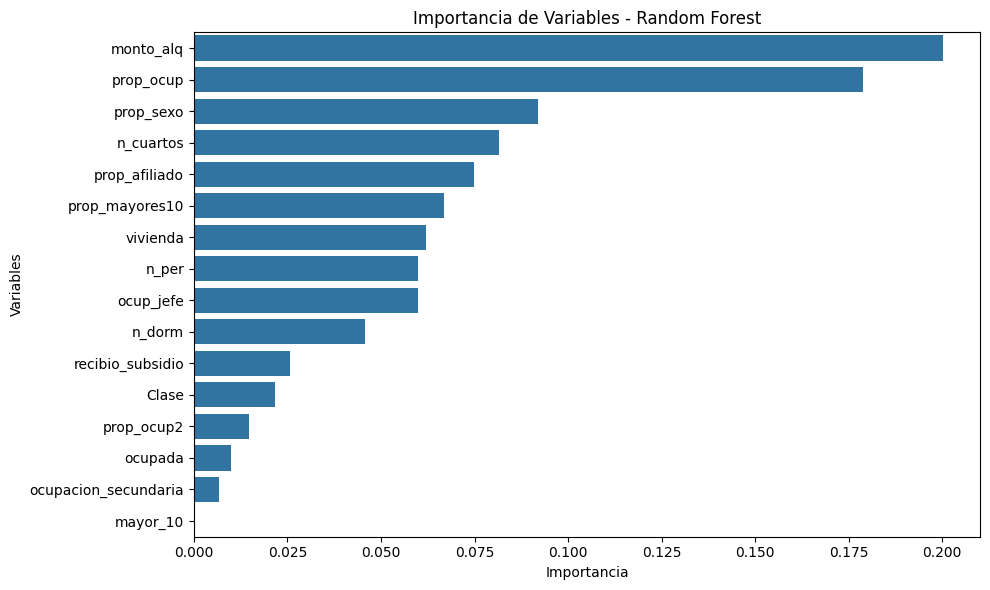

In [1408]:
importances = rf_model.feature_importances_
features = X_train.columns

# Crear un DataFrame de importancia de caracter√≠sticas
importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Graficar importancia de caracter√≠sticas
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Importancia de Variables - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

### Random forest 2

Accuracy (nuevo): 0.5006
F1-Score (nuevo): 0.0660


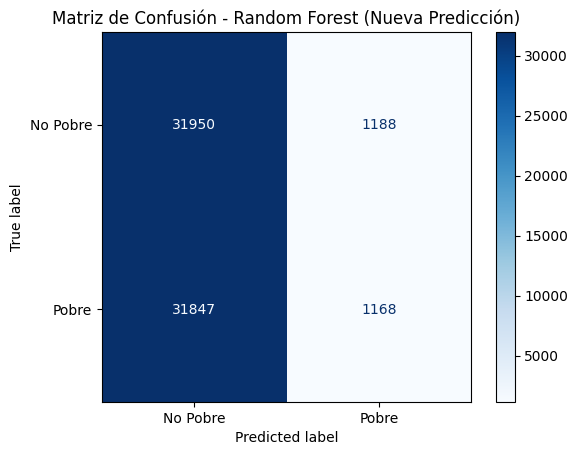

In [1422]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Seleccionar nuevas variables para la predicci√≥n
X_train_new = X_train[['n_cuartos', 'n_dorm', 'vivienda', 'monto_alq']]
X_test_new = X_test[['n_cuartos', 'n_dorm', 'vivienda', 'monto_alq']]

# Entrenar nuevamente el modelo Random Forest
rf_model_new = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_new.fit(X_train_new, y_train)

# Realizar nuevas predicciones
y_pred_new = rf_model_new.predict(X_test_new)

# Evaluaci√≥n
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new)

print(f"Accuracy (nuevo): {accuracy_new:.4f}")
print(f"F1-Score (nuevo): {f1_new:.4f}")

# Matriz de confusi√≥n
cm_new = confusion_matrix(y_test, y_pred_new)
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=["No Pobre", "Pobre"])
disp_new.plot(cmap="Blues")
plt.title("Matriz de Confusi√≥n - Random Forest (Nueva Predicci√≥n)")
plt.show()

### Resultados del modelo Random Forest con nueva especificaci√≥n

#### M√©tricas de desempe√±o:
- **Accuracy (nuevo):** 0.5006
- **F1-Score (nuevo):** 0.0660

#### Interpretaci√≥n:
La matriz de confusi√≥n muestra un desempe√±o moderado del modelo al intentar clasificar entre "Pobre" y "No Pobre". El **accuracy** indica que aproximadamente el 50.06% de las predicciones fueron correctas. Sin embargo, el **F1-Score** es muy bajo (0.0660), lo que se√±ala una deficiente capacidad del modelo para manejar un balance entre precisi√≥n y exhaustividad, especialmente para la clase minoritaria ("Pobre").

#### Observaciones:
El bajo F1-Score puede ser un reflejo de un desbalance en las clases o una insuficiencia del modelo para capturar patrones significativos en las variables seleccionadas para esta nueva especificaci√≥n. Puede ser necesario ajustar hiperpar√°metros, probar otras especificaciones de variables o considerar t√©cnicas de balanceo de clases para mejorar el desempe√±o.

#### Matriz de Confusi√≥n:
La matriz de confusi√≥n muestra:
- **31,950** verdaderos negativos (correctamente clasificados como "No Pobre").
- **1,188** falsos positivos (incorrectamente clasificados como "Pobre").
- **31,847** falsos negativos (incorrectamente clasificados como "No Pobre").
- **1,168** verdaderos positivos (correctamente clasificados como "Pobre").

La visualizaci√≥n de la matriz de confusi√≥n se presenta a continuaci√≥n:
![Matriz de Confusi√≥n - Random Forest (Nueva Predicci√≥n)](file-3UTCCcAEAsXbMFYQgqjV4B)

### Logit


Accuracy: 0.4992
F1-Score: 0.1717


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


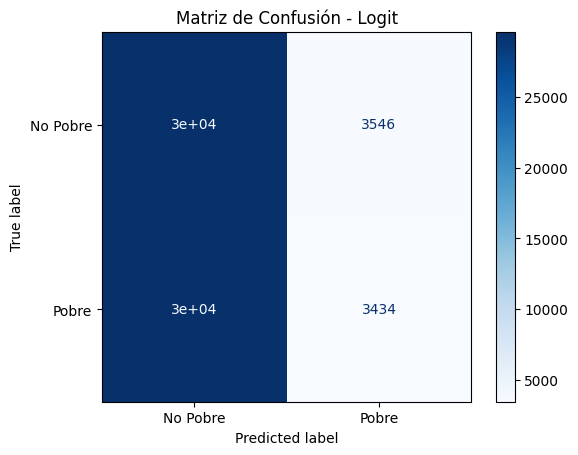

In [1399]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Crear y entrenar el modelo Logit
logit_model = LogisticRegression(random_state=42, max_iter=1000)
logit_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = logit_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

# Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Pobre", "Pobre"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusi√≥n - Logit")
plt.show()

### Resultados del Modelo Logit

#### 1. **Entrenamiento del Modelo**
Se entren√≥ un modelo de regresi√≥n log√≠stica con las siguientes configuraciones:
- **Random State**: 42 (para reproducibilidad de los resultados).
- **M√°ximo de iteraciones**: 1000 (para intentar garantizar la convergencia del modelo).

#### 2. **Rendimiento del Modelo**
- **Accuracy**: 0.4992  
  Esto indica que el modelo tiene una precisi√≥n cercana al 50%, lo que sugiere que est√° prediciendo a un nivel equivalente al azar en este caso.
  
- **F1-Score**: 0.1717  
  El puntaje F1 es bajo, lo que refleja un desequilibrio en la predicci√≥n correcta de la clase "Pobre".

#### 3. **Problemas de Convergencia**
El modelo gener√≥ una advertencia de convergencia (`ConvergenceWarning`) debido a que alcanz√≥ el n√∫mero m√°ximo de iteraciones sin lograr converger. Esto puede ser causado por:
- Variables no escaladas adecuadamente.
- Complejidad del modelo en relaci√≥n con los datos.
  
**Recomendaciones para resolver este problema:**
- Escalar las variables con un m√©todo como `StandardScaler` o `MinMaxScaler`.
- Aumentar el valor de `max_iter` o utilizar otro solver, como `saga`.

#### 4. **Matriz de Confusi√≥n**
La matriz de confusi√≥n muestra el siguiente desglose de las predicciones:
- **Verdaderos Negativos** ("No Pobre" correctamente clasificado): ~30,000
- **Falsos Positivos** ("No Pobre" clasificado como "Pobre"): 3,546
- **Falsos Negativos** ("Pobre" clasificado como "No Pobre"): ~30,000
- **Verdaderos Positivos** ("Pobre" correctamente clasificado): 3,434

Esto indica que el modelo tiene dificultades significativas para clasificar correctamente la clase "Pobre".

#### 5. **Visualizaci√≥n**
Se utiliz√≥ una visualizaci√≥n de la matriz de confusi√≥n para interpretar los resultados, donde se observa un gran desequilibrio entre las clases correctamente predichas y las incorrectas.

### Conclusi√≥n
El modelo Logit, en su configuraci√≥n actual, muestra un rendimiento limitado debido a problemas de convergencia y baja capacidad para distinguir entre las clases. Se recomienda escalar los datos y ajustar los hiperpar√°metros antes de considerar un cambio a un modelo alternativo.

### lOGIT 2

Accuracy (nueva especificaci√≥n): 0.5009
F1-Score (nueva especificaci√≥n): 0.0097
Coeficientes beta del modelo Logit (nueva especificaci√≥n):
ocupada     -0.566882
n_cuartos   -0.349746
mayor_10    -0.345335
ocup_jefe    0.266398
dtype: float64


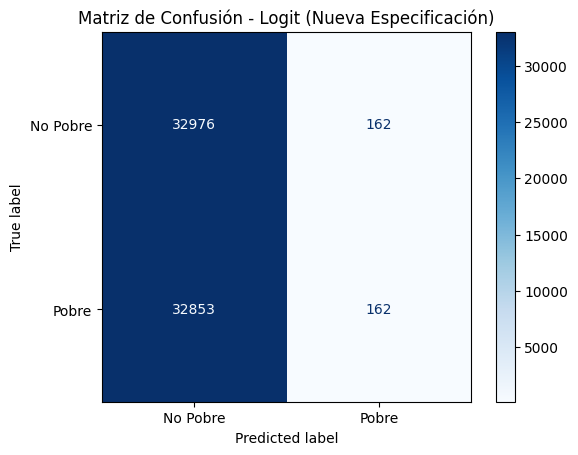

In [1427]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Nueva especificaci√≥n: seleccionar un subconjunto de variables
X_train_logit = X_train[["mayor_10", "ocupada", "n_cuartos", "ocup_jefe"]]
X_test_logit = X_test[["mayor_10", "ocupada", "n_cuartos", "ocup_jefe"]]

# Crear y entrenar el modelo Logit
logit_model_new = LogisticRegression(random_state=42, max_iter=1000)
logit_model_new.fit(X_train_logit, y_train)

# Realizar predicciones
y_pred_new = logit_model_new.predict(X_test_logit)

# Calcular m√©tricas
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new)
print(f"Accuracy (nueva especificaci√≥n): {accuracy_new:.4f}")
print(f"F1-Score (nueva especificaci√≥n): {f1_new:.4f}")

# Mostrar los coeficientes beta del modelo
coeficientes = pd.Series(logit_model_new.coef_[0], index=X_train_logit.columns)
print("Coeficientes beta del modelo Logit (nueva especificaci√≥n):")
print(coeficientes.sort_values())

# Matriz de confusi√≥n
cm_new = confusion_matrix(y_test, y_pred_new)
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=["No Pobre", "Pobre"])
disp_new.plot(cmap="Blues")
plt.title("Matriz de Confusi√≥n - Logit (Nueva Especificaci√≥n)")
plt.show()

### Linear Regresion

In [1413]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
import numpy as np

# Crear y entrenar el modelo de Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = linear_model.predict(X_test)

# Calcular el MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Error cuadr√°tico medio (MSE) en prueba: {mse:.4f}")

# Convertir predicciones continuas a etiquetas binarias usando un umbral
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Calcular m√©tricas
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

# Mostrar los coeficientes del modelo
coeficientes = pd.Series(linear_model.coef_, index=X_train.columns)
print("Coeficientes del modelo de Linear Regression:")
print(coeficientes.sort_values())

Error cuadr√°tico medio (MSE) en prueba: 0.3752
Accuracy: 0.5009
F1-Score: 0.1136
Coeficientes del modelo de Linear Regression:
mayor_10               -3.973398e-01
prop_ocup              -3.335809e-01
recibio_subsidio       -1.700861e-01
prop_mayores10         -1.077839e-01
prop_afiliado          -7.663576e-02
n_cuartos              -4.842768e-02
n_dorm                 -4.575994e-02
prop_ocup2             -1.926916e-02
prop_sexo              -1.492740e-02
ocup_jefe              -4.792610e-03
ocupacion_secundaria   -2.306650e-03
monto_alq              -1.065516e-09
vivienda                3.114647e-02
n_per                   5.616553e-02
Clase                   6.166077e-02
ocupada                 9.219188e-02
dtype: float64


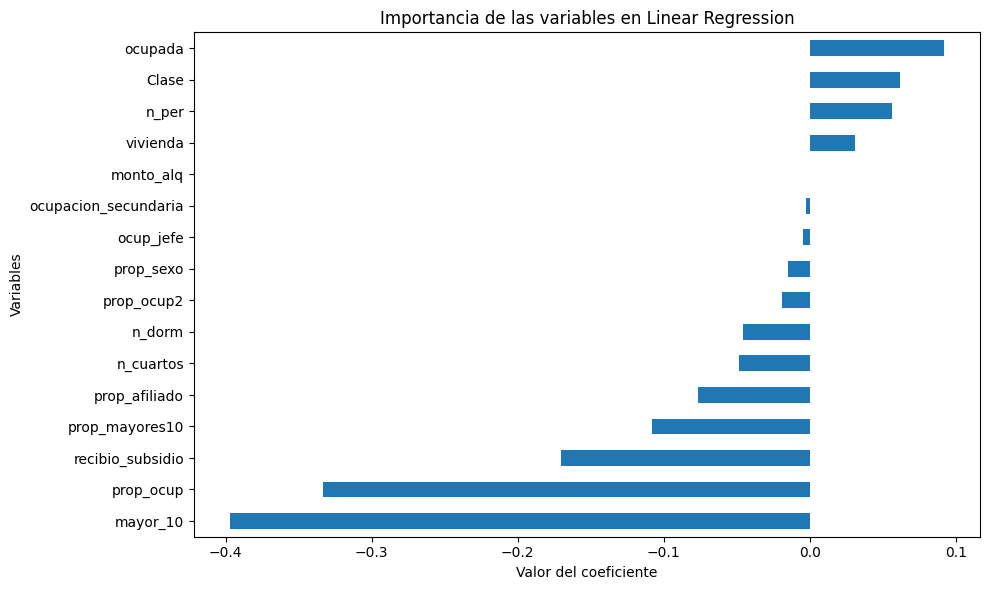

In [1414]:
import matplotlib.pyplot as plt

# Graficar los coeficientes
plt.figure(figsize=(10, 6))
coeficientes.sort_values().plot(kind='barh')
plt.title("Importancia de las variables en Linear Regression")
plt.xlabel("Valor del coeficiente")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

### lINEAR rEGRESSION 2

In [1419]:
X_train.columns

Index(['n_cuartos', 'n_dorm', 'vivienda', 'monto_alq', 'n_per', 'Clase',
       'prop_sexo', 'ocup_jefe', 'ocupada', 'prop_ocup', 'mayor_10',
       'prop_mayores10', 'recibio_subsidio', 'ocupacion_secundaria',
       'prop_ocup2', 'prop_afiliado'],
      dtype='object')

Error cuadr√°tico medio (MSE): 0.3467
Accuracy: 0.5009
F1-Score: 0.0001
Coeficientes del modelo:
mayor_10    -0.452033
ocupada     -0.082221
n_cuartos   -0.050183
ocup_jefe    0.038656
dtype: float64


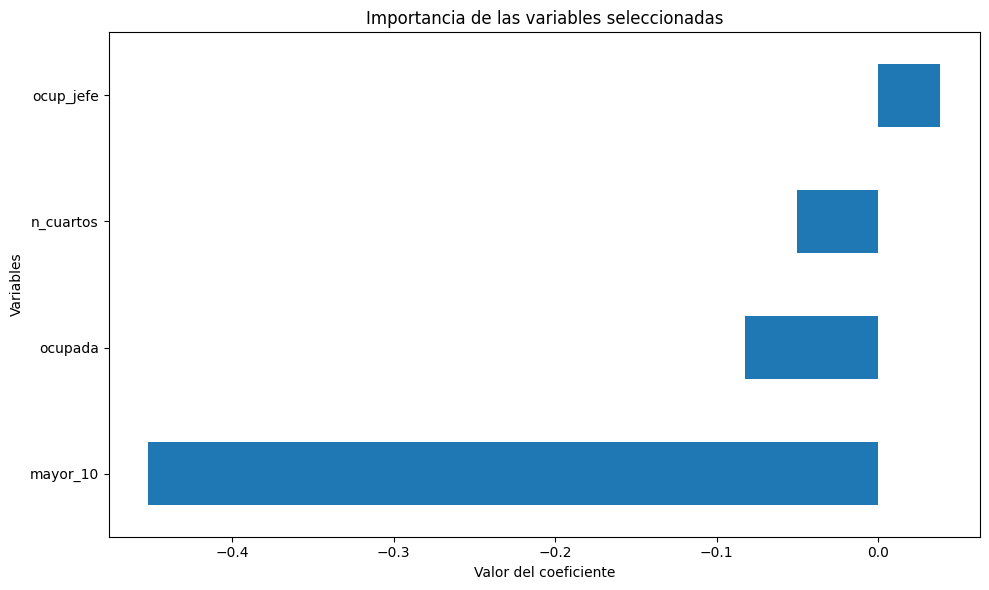

In [1420]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
import pandas as pd

# Seleccionar las nuevas variables
selected_features = ['mayor_10', 'n_cuartos', 'ocupada', 'ocup_jefe']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Crear y entrenar el modelo
linear_model_selected = LinearRegression()
linear_model_selected.fit(X_train_selected, y_train)

# Realizar predicciones
y_pred_selected = linear_model_selected.predict(X_test_selected)

# Calcular el MSE
mse_selected = mean_squared_error(y_test, y_pred_selected)
print(f"Error cuadr√°tico medio (MSE): {mse_selected:.4f}")

# Convertir predicciones continuas a etiquetas binarias usando un umbral
threshold = 0.5
y_pred_binary_selected = (y_pred_selected >= threshold).astype(int)

# Calcular m√©tricas
accuracy_selected = accuracy_score(y_test, y_pred_binary_selected)
f1_selected = f1_score(y_test, y_pred_binary_selected)

print(f"Accuracy: {accuracy_selected:.4f}")
print(f"F1-Score: {f1_selected:.4f}")

# Mostrar los coeficientes del modelo
coeficientes_selected = pd.Series(linear_model_selected.coef_, index=selected_features)
print("Coeficientes del modelo:")
print(coeficientes_selected.sort_values())

# Graficar los coeficientes
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
coeficientes_selected.sort_values().plot(kind='barh')
plt.title("Importancia de las variables seleccionadas")
plt.xlabel("Valor del coeficiente")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

### Resultados del Modelo de Regresi√≥n Lineal con Variables Seleccionadas

#### M√©tricas de Evaluaci√≥n
- **Error cuadr√°tico medio (MSE)**: 0.3467
- **Accuracy**: 0.5009
- **F1-Score**: 0.0001

#### Importancia de las Variables (Coeficientes)
| Variable   | Coeficiente |
|------------|-------------|
| mayor_10   | -0.452033   |
| ocupada    | -0.082221   |
| n_cuartos  | -0.050183   |
| ocup_jefe  |  0.038656   |

#### Interpretaci√≥n
- **mayor_10**: La proporci√≥n de mayores de 10 a√±os tiene el impacto negativo m√°s significativo en las predicciones del modelo. Un aumento en esta variable est√° asociado con una disminuci√≥n en el resultado predicho.
- **ocupada** y **n_cuartos**: Ambas variables tienen un efecto negativo leve sobre la variable objetivo, seg√∫n los coeficientes.
- **ocup_jefe**: Es la √∫nica variable con un coeficiente positivo, lo que indica que una mayor ocupaci√≥n del jefe del hogar tiene una relaci√≥n positiva, aunque peque√±a, con la variable objetivo.

#### Observaciones
- El **Accuracy** y el **F1-Score** son muy bajos, lo que indica que este modelo tiene un rendimiento limitado para capturar las relaciones subyacentes en los datos.
- Los coeficientes negativos predominan, lo que refleja que estas caracter√≠sticas influyen de manera adversa en el resultado del modelo lineal.
- Este modelo podr√≠a no ser el m√°s adecuado para este problema espec√≠fico y puede

### Comparacion modelos

Error cuadr√°tico medio (MSE) en prueba: 0.3752
Accuracy: 0.5009
F1-Score: 0.1136

Error cuadr√°tico medio (MSE): 0.3467
Accuracy: 0.5009
F1-Score: 0.0001


                Modelo  Accuracy  F1-Score     MSE
0    Linear Regression    0.5009    0.1136  0.3752
1  Linear Regression 2    0.5009    0.0001  0.3467
2          Elastic Net    0.5009       NaN  0.3395
3        Random Forest    0.4991    0.2384     NaN
4      Random Forest 2    0.5006    0.0660     NaN
5                 CART    0.5005    0.1883     NaN
6                Logit    0.4992    0.1717     NaN
7              Logit 2    0.5009    0.0097     NaN


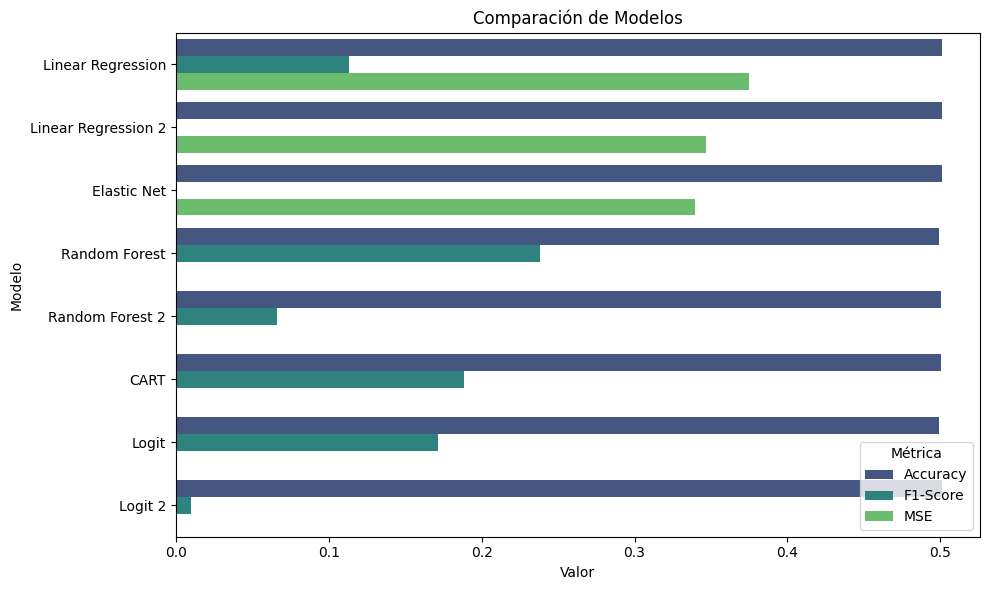

In [1426]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos de las m√©tricas de los modelos
data = {
    "Modelo": ["Linear Regression", "Linear Regression 2", "Elastic Net", "Random Forest", "Random Forest 2", "CART", "Logit", "Logit 2"],
    "Accuracy": [0.5009, 0.5009, 0.5009, 0.4991, 0.5006, 0.5005, 0.4992, 0.5009],  # Agregar valores correctos
    "F1-Score": [0.1136, 0.0001, None, 0.2384, 0.0660, 0.1883, 0.1717, 0.0097],  # Agregar valores correctos
    "MSE": [0.3752, 0.3467, 0.3395, None, None, None, None, None],  # Solo para Elastic Net y Linear Regression
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Mostrar la tabla
print(df)

# Graficar los resultados
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df.melt(id_vars=["Modelo"], var_name="M√©trica", value_name="Valor"),
    x="Valor", y="Modelo", hue="M√©trica", palette="viridis"
)
plt.title("Comparaci√≥n de Modelos")
plt.xlabel("Valor")
plt.ylabel("Modelo")
plt.legend(title="M√©trica")
plt.tight_layout()
plt.show()

Los resultados obtenidos muestran que el rendimiento general de los modelos es limitado, con valores de accuracy cercanos al 50% en todos los casos. Este nivel de precisi√≥n sugiere que los modelos apenas superan el azar en la predicci√≥n de la variable objetivo, lo que podr√≠a deberse a una complejidad inherente en los datos o a una falta de informaci√≥n relevante en las variables explicativas.

Entre los modelos evaluados, el F1-Score se presenta como una m√©trica clave para analizar la capacidad de los modelos de manejar el balance entre precisi√≥n y exhaustividad. En este aspecto, el modelo de Random Forest destaca con un F1-Score de 0.2384, indicando que, aunque no es perfecto, logra capturar la se√±al de la clase ‚ÄúPobre‚Äù con mayor eficacia que los dem√°s. Sin embargo, modelos como CART (F1-Score: 0.1883) y Logit (F1-Score: 0.1717) tambi√©n ofrecen un rendimiento razonable, aunque algo inferior.

Para los modelos que producen predicciones continuas, como Elastic Net y Linear Regression, se calcul√≥ el error cuadr√°tico medio (MSE). En este caso, Elastic Net mostr√≥ el menor error (MSE: 0.3395), lo que lo posiciona como el modelo m√°s adecuado para tareas de regresi√≥n dentro de este conjunto de datos. Esto sugiere que Elastic Net es capaz de ajustar los valores continuos de manera m√°s precisa que otros modelos, posiblemente debido a su capacidad para manejar relaciones lineales penalizando complejidad excesiva.

Por otro lado, las especificaciones simplificadas (como Linear Regression 2 y Logit 2) no mejoraron el rendimiento significativamente. Aunque mantuvieron niveles similares de accuracy en comparaci√≥n con las especificaciones originales, sus valores m√°s bajos de F1-Score indican que las simplificaciones resultaron en una p√©rdida de capacidad para capturar patrones relevantes en los datos.

En resumen, el modelo de Random Forest es el m√°s destacado para clasificaci√≥n debido a su F1-Score, mientras que Elastic Net sobresale para predicciones continuas por su menor MSE. Estos resultados subrayan la importancia de seleccionar el modelo y la m√©trica m√°s adecuados seg√∫n los objetivos del an√°lisis.

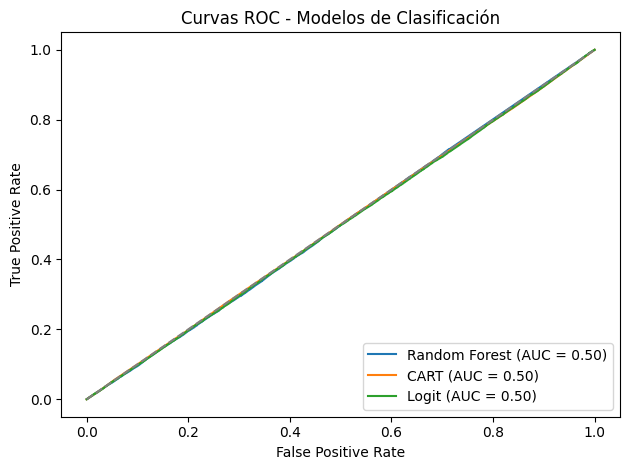

In [1405]:
from sklearn.metrics import roc_curve, auc

# Calcular curva ROC para cada modelo
for model_name, model in [("Random Forest", rf_model), ("CART", cart_model), ("Logit", logit_model)]:
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Gr√°fica de la curva ROC
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("Curvas ROC - Modelos de Clasificaci√≥n")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

Para el caso de las variables que ya est√°n en la base de hogares, se pueden considerar como
interesantes las siguientes: 

Dominio: hay que codificarla primero. Te recoge el efecto fijo de la regi√≥n

p5010 El hacinamiento puede ser importante.

p5090 si es vivienda propia

p5130 cuanto piensa que hubiera pagado de alquiler? te puede recoger no solo un proxy del valor de la casa sino que los hogares con menores recursos van a percibir menores valores y viceversa

Nper: numero de personas, existe correlaci√≥n negativa entre tama√±o del hogar e ingreso

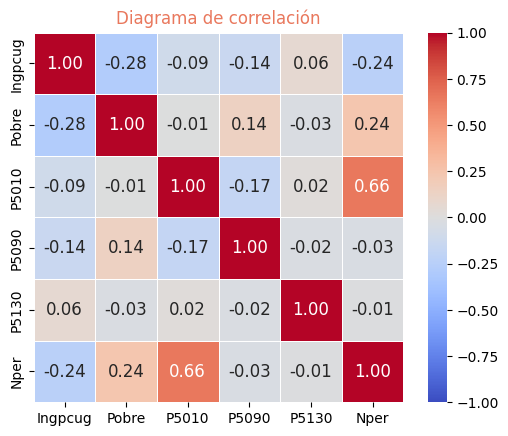

In [99]:
#Heatmap de la base hogares con las variables interesantes

columnas = ['Ingpcug', 'Pobre', 'P5010', 'P5090', 'P5130', 'Nper']
corr = train_hogares[columnas].corr()

# Crear el mapa de calor con escala fija de -1 a 1
sns.heatmap(
    corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, fmt='.2f',
    cbar=True, square=True, annot_kws={'size': 12}, linewidth=.5,
    vmin=-1, vmax=1  # Configurar la escala fija de colores
)

# Personalizar el gr√°fico
plt.title('Diagrama de correlaci√≥n', color='#E9785D')
plt.show()

**ACLARO: ESTO LE DA ESTRUCTURA, NO ES QUE SEA EXCLUYENTE LAS VARIABLES QUE PUSE**

A continuaci√≥n, transformamos ciertas variables de la base de individuos para luego utilizarlas junto con los hogares. Estas variables se intuye que pueden ser buenas predictoras. Las mismas son:

P6020: sexo: creamos _prop_sex_ proporci√≥n de masculinos en la casa puede ser bueno para predecir. 

p6210: creamos _max_level_edu_. creamos una variable que sea el m√°ximo nivel educativo alcanzado por los integrantes del hogar

p6430: creamos _ocup_jefe_. posici√≥n ocupacional de la 1ra actividad. nos podemos quedar con lo que hace el jefe de hogar.

p6920: creamos _cant_blanco_. Esta variable nos dice si est√° cotizando a un fondo de pensiones. crear una variable que nos diga la cantidad de empleados formales que tiene el hogar. La variable p6920 toma 3 valores: 1: si, 2: no, 3: ya es pensionado. Solo vamos a tomar 1 si est√° cotizando y 0 en cualquier otro caso.

Oc: cant_ocup. sumamos todos los ocupados que tiene la casa.


In [13]:
#Cambiamos el valor de mujer de 2 a 0 para poder hacer c√°lculos luego

train_personas['P6020'] = train_personas['P6020'].replace(2, 0)

In [18]:
#Calculamos la proporci√≥n de hombres en el hogar:

# Contar cu√°ntos hombres hay en cada hogar (P6020 == 1)
hombres_por_hogar = train_personas[train_personas['P6020'] == 1].groupby('id')['P6020'].count()

# Contar el total de integrantes por hogar
total_por_hogar = train_personas.groupby('id')['P6020'].count()

# Calcular la proporci√≥n de hombres en cada hogar
train_personas['prop_sex'] = train_personas['id'].map(hombres_por_hogar) / train_personas['id'].map(total_por_hogar)


In [16]:
#Creamos una variable que nos diga el m√°ximo nivel educativo de cada integrante del hogar

# Filtrar los valores v√°lidos de 'P6210' (1 a 6, excluyendo 9)
train_personas_filtrado = train_personas[train_personas['P6210'] != 9]

# Agrupar por el identificador del hogar (asum√≠ que hay una columna 'hogar_id' que identifica a cada hogar)
# Luego, calcular el m√°ximo nivel educativo alcanzado en cada hogar
train_personas['mal_level_edu'] = train_personas_filtrado.groupby('id')['P6210'].transform('max')

# Si hay hogares con valores 'P6210' == 9 (sin datos v√°lidos), asignamos el valor correspondiente para esos hogares
train_personas['mal_level_edu'] = train_personas.groupby('id')['mal_level_edu'].transform('max')

# Mostrar las primeras filas para verificar
print(train_personas[['id', 'P6210', 'mal_level_edu']].head())


                         id  P6210  mal_level_edu
0  8d0193e328305a042001a35f    3.0            5.0
1  8d0193e328305a042001a35f    2.0            5.0
2  8d0193e328305a042001a35f    5.0            5.0
3  8d0193e328305a042001a35f    2.0            5.0
4  8d0193e328305a042001a35f    4.0            5.0


In [20]:
#Creamos la variable "ocup_jefe" que toma el valor de la ocupaci√≥n principal del jefe de hogar

# Filtrar la fila correspondiente al jefe del hogar (P6050 == 1)
jefe_hogar = train_personas[train_personas['P6050'] == 1]

# Crear un diccionario con la relaci√≥n 'id' del hogar y la posici√≥n ocupacional del jefe (P6430)
jefe_ocupacion = jefe_hogar.set_index('id')['P6430'].to_dict()

# Asignar la posici√≥n ocupacional del jefe a la nueva variable 'ocup_jefe'
train_personas['ocup_jefe'] = train_personas['id'].map(jefe_ocupacion)


In [24]:
#Contamos la cantidad de personas trabajando en blanco que tiene el hogar

# Crear una variable que sea 1 si la persona est√° en blanco (P6870 == 1) y 0 en cualquier otro caso
train_personas['blanco'] = (train_personas['P6870'] == 1).astype(int)

# Agrupar por 'id' y sumar la cantidad de personas en blanco en cada hogar
cant_blanco_por_hogar = train_personas.groupby('id')['blanco'].sum()

# Asignar la suma de personas en blanco a la nueva variable 'cant_blanco' en el DataFrame original
train_personas['cant_blanco'] = train_personas['id'].map(cant_blanco_por_hogar)


In [28]:
# Crear una variable que sea 1 si la persona est√° ocupada (Oc == 1) y 0 en cualquier otro caso
train_personas['ocupada'] = (train_personas['Oc'] == 1).astype(int)

# Agrupar por 'id' y sumar la cantidad de personas ocupadas en cada hogar
cant_ocupada_por_hogar = train_personas.groupby('id')['ocupada'].sum()

# Asignar la suma de personas ocupadas a la nueva variable 'cant_ocupada' en el DataFrame original
train_personas['cant_ocup'] = train_personas['id'].map(cant_ocupada_por_hogar)


In [30]:
train_personas['cant_ocup'].value_counts()

cant_ocup
1     189092
2     188529
3      75167
0      46864
4      28720
5       9772
6       3211
7       1026
8        469
9        191
10        33
14        22
11        13
Name: count, dtype: int64

In [34]:
#Agregamos a la base de hogares las variables creadas en la base de personas

# Agrupar las variables creadas por 'id' en la base 'train_personas'
df_personas_agg = train_personas.groupby('id')[['mal_level_edu', 'prop_sex', 'ocup_jefe', 'cant_blanco', 'cant_ocup']].mean()

# Unir la base 'train_hogares' con las variables agregadas de 'train_personas'
train_hogares = train_hogares.merge(df_personas_agg, on='id', how='left')


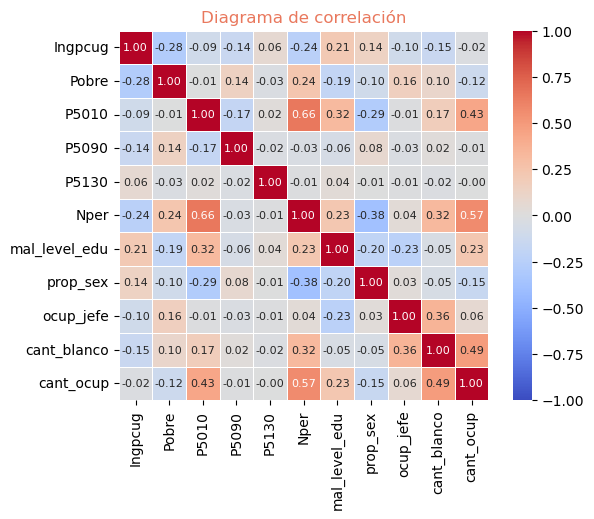

In [37]:
#Ahora exponemos la matriz de correlacion con todas las variables. 

columnas = ['Ingpcug', 'Pobre', 'P5010', 'P5090', 'P5130', 'Nper', 'mal_level_edu', 'prop_sex', 'ocup_jefe', 'cant_blanco', 'cant_ocup']
corr = train_hogares[columnas].corr()

# Crear el mapa de calor con escala fija de -1 a 1
sns.heatmap(
    corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, fmt='.2f',
    cbar=True, square=True, annot_kws={'size': 8}, linewidth=.5,
    vmin=-1, vmax=1  # Configurar la escala fija de colores
)

# Personalizar el gr√°fico
plt.title('Diagrama de correlaci√≥n', color='#E9785D')
plt.show()

# Desarrollo 

Nuestro objetivo ahora es armar un modelo que prediga si un hogar es pobre o no. Para eso vamos a utilizar los diferentes m√©todos:

√Årboles (CARTs), Random Forest y boosting. Tambi√©n se pueden utilizar Linear Regression, Logit o Elastic Net

### Arboles (CARTs)

In [8]:
#importamos el algoritmo para python
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text #Para exportar arboles


In [ ]:
#Ac√° reemplazar por las variables que vayamos a usar
X = db[['DCBD', 'habitaciones']]
y = db['price']

# Create the decision tree model
mytree = DecisionTreeRegressor(max_leaf_nodes=3) #Hay que definir el n√∫mero m√°ximo de nodos

# Fit the model
mytree.fit(X, y)

Lo siguiente lo saqu√© de clase: 

Una vez entrenado el √°rbol, se puede representar mediante la combinaci√≥n de las funciones  `export_text()` y `plot_tree()`. 
 - La funci√≥n `export_text()` la estructura del √°rbol  y valor medio de la variable respuesta en cada nodo.  
 - La funci√≥n `plot_tree()` dibuja la estructura del √°rbol y muestra el n√∫mero de observaciones y valor medio de la variable respuesta en cada nodo.

In [ ]:
#Esto deber√≠a correr bien as√≠, ya que todo lo definimos arriba
texto_modelo = export_text(
                    decision_tree = mytree,
                    feature_names = list(X.columns)
               )
print(texto_modelo)

In [9]:
from sklearn.tree import plot_tree

In [ ]:
# Estructura del √°rbol creado. Tambien deberia correr, solo le debo cambiar class_names
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 5))

print(f"Profundidad del √°rbol: {mytree.get_depth()}")
print(f"N√∫mero de nodos terminales: {mytree.get_n_leaves()}")

plot = plot_tree(
            decision_tree = mytree,
            feature_names = X.columns,
            class_names   = 'price', #Esto habr√≠a que cambiar.  Es la variable que etiqueta. \\
            #Debieramos cambiarla por Pobre/No pobre, ya que es lo q estamos clasificando aca
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

`DecisionTreeRegressor` del m√≥dulo `sklearn.tree` tiene  hiperpar√°metros, que nos permitir√°n "controlar" el sobreajuste:

  - `max_depth`: profundidad m√°xima que puede alcanzar el √°rbol.

  - `max_leaf_nodes`: n√∫mero m√°ximo de nodos terminales.

  - `min_samples_leaf`: n√∫mero m√≠nimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la divisi√≥n. Si es un valor decimal se interpreta como fracci√≥n del total de observaciones de entrenamiento `ceil(min_samples_split * n_samples)`.

  
  - `ccp_alpha`=0.0 Cost complexity prunning
  
  - `random_state`: semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.

Como en todo estudio de regresi√≥n, no solo es importante ajustar el modelo, sino tambi√©n cuantificar su capacidad para predecir nuevas observaciones. Para poder hacer la posterior evaluaci√≥n, se dividen los datos en dos grupos, uno de entrenamiento y otro de test.


# Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor
import multiprocessing

In [ ]:
# Creaci√≥n del modelo
# ==============================================================================
modelo_forest = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 1,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo_forest.fit(X_train, y_train)

Prediccion y evaluacion del modelo

In [ ]:
# Error de test del modelo inicial
# ==============================================================================
predicciones_forest = modelo_forest.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones_forest,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")


## Optimizaci√≥n de Hiperparametros

El modelo inicial se ha entrenado utilizando 10 √°rboles (n_estimators=10) y manteniendo el resto de hiperpar√°metros con su valor por defecto. Al ser hiperpar√°metros, no se puede saber de antemano cu√°l es el valor m√°s adecuado, la forma de identificarlos es mediante el uso de estrategias de validaci√≥n, por ejemplo validaci√≥n cruzada.

Los modelos Random Forest tienen la ventaja de disponer del Out-of-Bag error, lo que permite obtener una estimaci√≥n del error de test sin recurrir a la validaci√≥n cruzada, que es computacionalmente costosa. En la implementaci√≥n de RandomForestRegressor, la m√©trica devuelta como oob_score es el ùëÖ2, si se desea otra, se tiene que recurrir al m√©todo oob_decision_function_() para obtener las predicciones y con ellas calcular la m√©trica de inter√©s. Para una explicaci√≥n m√°s detallada consultar: Grid search de modelos Random Forest con out-of-bag error y early stopping.

Cabe tener en cuenta que, cuando se busca el valor √≥ptimo de un hiperpar√°metro con dos m√©tricas distintas, el resultado obtenido raramente es el mismo. Lo importante es que ambas m√©tricas identifiquen las mismas regiones de inter√©s.



   La clase RandomForestRegressor del m√≥dulo sklearn.ensemble contiene varios hiperpar√°metros. De entre todos ellos, destacan aquellos que detienen el crecimiento de los √°rboles, los que controlan el n√∫mero de √°rboles y predictores incluidos, y los que gestionan la paralelizaci√≥n:

   - `n_estimators`; n√∫mero de √°rboles incluidos en el modelo.

   - `max_depth`: profundidad m√°xima que pueden alcanzar los √°rboles.

   - `min_samples_split`: n√∫mero m√≠nimo de observaciones que debe de tener un nodo para que pueda dividirse. Si es un valor decimal se interpreta como fracci√≥n del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

   - `min_samples_leaf`: n√∫mero m√≠nimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la divisi√≥n. Si es un valor decimal se interpreta como fracci√≥n del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

   - `max_leaf_nodes`: n√∫mero m√°ximo de nodos terminales que pueden tener los √°rboles.

   - `max_features`: n√∫mero de predictores considerados a en cada divisi√≥n. Puede ser:
        Un valor entero
        Una fracci√≥n del total de predictores..
        ‚Äúsqrt‚Äù, raiz cuadrada del n√∫mero total de predictores.
        ‚Äúlog2‚Äù, log2 del n√∫mero total de predictores.
        None, utiliza todos los predictores.

   - `oob_score`: Si se calcula o no el out-of-bag R^2. Por defecto es False ya que aumenta el tiempo de entrenamiento.

   - `n_jobs`: n√∫mero de cores empleados para el entrenamiento. En random forest los √°rboles se ajustan de forma independiente, por lo la paralelizaci√≥n reduce notablemente el tiempo de entrenamiento. Con -1 se utilizan todos los cores disponibles.

   - `random_state`: semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.

#### N√∫mero de √°rboles

En Random Forest, el n√∫mero de √°rboles no es un hiperpar√°metro cr√≠tico en cuanto que, a√±adir √°rboles, solo puede hacer que mejorar el resultado. En Random Forest no se produce overfitting por exceso de √°rboles. Sin embargo, a√±adir √°rboles una vez que la mejora se estabiliza es una perdida te recursos computacionales.

In [ ]:
# Validaci√≥n empleando el Out-of-Bag error
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(10, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 1,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

In [ ]:
# Gr√°fico con la evoluci√≥n de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evoluci√≥n del out-of-bag-error vs n√∫mero √°rboles")
plt.legend();
print(f"Valor √≥ptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")
warnings.filterwarnings('default')

#### Max features

El valor de `max_features` es uno de los hiperpar√°metros m√°s importantes de random forest, ya que es el que permite controlar cu√°nto se decorrelacionan los √°rboles entre s√≠.

In [ ]:
# housing dataset correlation in heat map
housing_dataset_correlation = california_housing.corr()
plt.figure(figsize=(24,14))
sns.heatmap(housing_dataset_correlation, annot = True)

In [ ]:
# Validaci√≥n empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gr√°fico con la evoluci√≥n de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evoluci√≥n del out-of-bag-error vs n√∫mero de predictores")
plt.legend();
print(f"Valor √≥ptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

##### Grid search

Aunque el an√°lisis individual de los hiperpar√°metros es √∫til para entender su impacto en el modelo e identificar rangos de inter√©s, la b√∫squeda final no debe hacerse de forma secuencial, ya que cada hiperpar√°metro interacciona con los dem√°s. Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperpar√°metros.

In [ ]:
from sklearn.model_selection import ParameterGrid
# Grid Search Aleatorio basado en validaci√≥n cruzada
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

In [ ]:

# Grid de hiperpar√°metros evaluados
# ==============================================================================
param_grid = {'n_estimators': [100,150,200],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# B√∫squeda por grid search con validaci√≥n cruzada
# ==============================================================================
grid_forest_cv = RandomizedSearchCV(
            estimator  = RandomForestRegressor(random_state = 123),
            param_distributions = param_grid,
            scoring    = 'neg_root_mean_squared_error',
            n_jobs     = multiprocessing.cpu_count() - 1,
            n_iter=2, 
            cv=5, 
            random_state=42,
            refit=True
       )

grid_forest_cv.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_forest_cv.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)


# Mejores hiperpar√°metros por validaci√≥n cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperpar√°metros encontrados (cv)")
print("----------------------------------------")
print(grid_forest_cv.best_params_, ":", grid_forest_cv.best_score_, grid_forest_cv.scoring)


Una vez identificados los mejores hiperpar√°metros, se reentrena el modelo indicando los valores √≥ptimos en sus argumentos. Si en el GridSearchCV() se indica refit=True, este reentrenamiento se hace autom√°ticamente y el modelo resultante se encuentra almacenado en .best_estimator_.

In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_grid_forest_cv_final = grid_forest_cv.best_estimator_
predicciones_grid_forest_cv_final = modelo_grid_forest_cv_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones_grid_forest_cv_final,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

## Boosting trees

### Hiperpar√°metros

- $\lambda$ la tasa a la que aprende, los valores t√≠picos son 0.1, 0.01 o 0.001

In [ ]:
#################################333

## Estimaci√≥n Logit

\begin{align}
p_i &=\frac{e^{X_i\beta}}{1+e^{X_i\beta}}
\end{align}

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



# Convert 'history' and 'purpose' into dummy variables
db_dummies = pd.get_dummies(db, columns=['history', 'purpose','foreign'], drop_first=True)

# Separate the independent and dependent variables
X = db_dummies.drop('Default', axis=1)
y = db_dummies['Default']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
# Fit the logistic regression model
logit_model = LogisticRegression(max_iter=200 )
logit_model.fit(X_train,y_train)



## Prediction


\begin{align}
\hat{p}_i &=\frac{e^{X_i\hat{\beta}}}{1+e^{X_i\hat{\beta}}}
\end{align}

In [ ]:
y_test=pd.DataFrame(y_test)
y_test.head()

In [ ]:
# Predict the probabilities
y_test['prob_hat'] = logit_model.predict_proba(X_test)[:, 1]

# Display the first few rows of the specified columns
y_test.head(30)